In [1]:
import pyabf 
import numpy as np
import re
import os
import pandas as pd
import scipy
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def parse_file_name(foldername_string): 
    f_dict=re.match(r"(?P<date>\d{8})-(?P<time>\d{6})_(?P<construct>\w.+)_CS_(?P<coverslip>\w+)_cell_(?P<cell>\d+)(?P<protocol>\w+)?",foldername_string)
    return f_dict.groupdict()

In [3]:
my_dataframe  = pd.DataFrame(columns=['Construct_Num', 'PeakPhotoCurrent','RiseTime','HalfDecayTime','decayTrace'])
folder_path   = (r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\DATA_sept23")
numnum        = 0
halfDecayTime = 1
savingTrce    = 1
for foldername in os.listdir(folder_path):
    folder_path_in = os.path.join(folder_path,foldername+ '\\EPHYS\\')
    for files in os.listdir(folder_path_in):
        file_path_in = os.path.join(folder_path_in,files)
        if os.path.isfile(file_path_in):
            sweeps_average_add = []
            print(file_path_in)
            abf = pyabf.ABF(file_path_in)
            foldername_string = abf.abfFileComment
            if len(foldername_string)>10:
                fileNameParse = parse_file_name(foldername_string)
                constructName = fileNameParse['construct']
                for sweep in abf.sweepList:
                    abf.setSweep(sweep,0)
                    baselineCheck = np.mean(abf.sweepY[int(50000*0.15):int(50000*0.20)])
                    if baselineCheck<-200:
                        break
                    numnum = numnum+1
                    abf.setSweep(sweep,0,baseline=[0.15,0.20])
                    sweep_average = np.mean(abf.sweepY[int(50000*1.68):int(50000*1.71)])
                    sweeps_average_add.append(sweep_average)
                    if sweep==5:
                        try:
                            abf.setSweep(sweep,6)
                            checkingRise  = abf.sweepY[int(50000*1.65):int(50000*1.67)]
                            checkingDecay = abf.sweepY[int(50000*1.7):int(50000*1.75)]
                            stimOn = np.argwhere(checkingRise<0.05)[0][0]
                            stimOff = np.argwhere(checkingDecay>4.95)[0][0]
                            abf.setSweep(sweep,0,baseline=[0.15,0.20])
                            checkingRise  = abf.sweepY[int(50000*1.65):int(50000*1.67)]
                            checkingDecay = abf.sweepY[int(50000*1.7):int(50000*1.75)]
                            targetValuePeak  = 0.8*np.min(checkingRise)
                            riseTime = np.argmin(np.abs(checkingRise-targetValuePeak))-stimOn
                            initiationDecayT = checkingDecay[stimOff+1]
                            initiationDecayIndex = np.argmin(np.abs(checkingDecay-initiationDecayT))
                            targetValueBasic = 0.05*initiationDecayT
                            endOfDecay = np.argmin(np.abs(checkingDecay-targetValueBasic))
                            savingTrce = checkingDecay[initiationDecayIndex:endOfDecay]
                            halfDecayTime = np.abs(np.abs(checkingDecay)-(np.abs(initiationDecayT)/2)).argmin()-stimOff
                        except:
                            riseTime = 10**6
                            halfDecayTime= 10**6
                if baselineCheck<-200:
                    continue 
                try:
                    dataForRow = {'Construct_Num':constructName,'PeakPhotoCurrent':np.min(sweeps_average_add),'RiseTime':(riseTime/50),'HalfDecayTime':(halfDecayTime/50),'decayTrace':(savingTrce)/np.min(savingTrce)}
                    my_dataframe.loc[numnum] = (dataForRow)
                except: 
                    pass
            else:
                continue


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\omeri\\OneDrive - weizmann.ac.il\\Desktop\\DATA_sept23'

In [ ]:
my_dataframe_filterd = my_dataframe[my_dataframe['PeakPhotoCurrent']<-300]

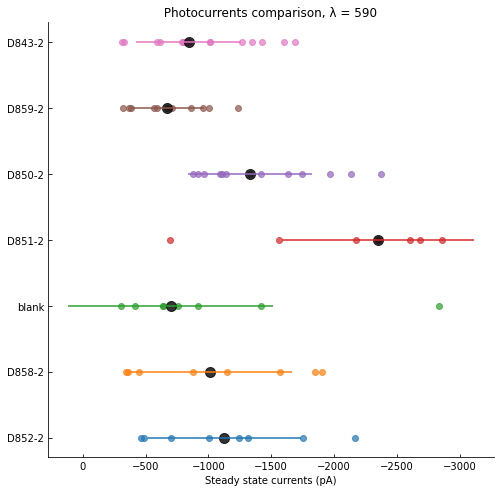

In [ ]:
## blank is D660 construct!! make sure to add it also to the rest of the analysis. 

plt.figure(figsize=(8,8))
exclude_groups = ['AAV357-1', 'AAV356-1']
filtered_data = my_dataframe_filterd[~my_dataframe_filterd['Construct_Num'].isin(exclude_groups)]
for group in filtered_data['Construct_Num'].unique():
    group_data = filtered_data[filtered_data['Construct_Num'] == group]
    plt.scatter(group_data['PeakPhotoCurrent'], [group]*len(group_data), label=group, alpha=0.7)
    average_value = group_data['PeakPhotoCurrent'].median()
    std_value = group_data['PeakPhotoCurrent'].std()
    plt.scatter(average_value, group, color='black', marker='o', label=f'{group} Average',alpha=0.8, s=100)
    plt.errorbar(average_value, group,xerr = std_value)
plt.gca().invert_xaxis()
plt.title(" Photocurrents comparison, λ = 590 ")
plt.xlabel("Steady state currents (pA)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()


In [ ]:
f_oneway(filtered_data['Construct_Num'] =='D843-2',filtered_data['Construct_Num'] =='D859-2',filtered_data['Construct_Num'] =='D850-2',filtered_data['Construct_Num'] =='D851-2',filtered_data['Construct_Num'] =='D858-2',filtered_data['Construct_Num'] =='D852-2')

F_onewayResult(statistic=1.3776, pvalue=0.23153615898256366)

In [ ]:
## i would like to plot now the decey and rise time for the giving constructs. 
#I can extract the decey and rise time from the fine by measuring the time from the beginnig of stimulation until the max pick photocurrent. 
# #the decey time will be the value from the off pulse until 5% from baseline level.

In [ ]:
filtered_data = filtered_data[filtered_data['RiseTime']<10]
filtered_data = filtered_data[filtered_data['HalfDecayTime']<8]

In [ ]:
filtered_data['Construct_Num'] = filtered_data['Construct_Num'].replace('blank','D660')

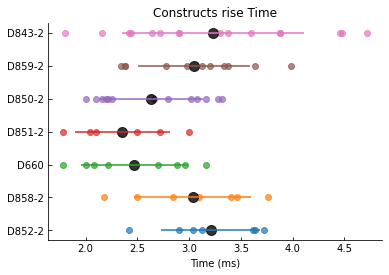

In [ ]:
## The rise time is calculated from baseline to 0.8*peak photocurrent. 

for group in filtered_data['Construct_Num'].unique():
    group_data = filtered_data[filtered_data['Construct_Num'] == group]
    plt.scatter(group_data['RiseTime'], [group]*len(group_data), label=group, alpha=0.7)
    average_value = group_data['RiseTime'].mean()
    std_value = group_data['RiseTime'].std()
    plt.scatter(average_value, group, color='black', marker='o', label=f'{group} Average',alpha=0.8, s=100)
    plt.errorbar(average_value, group,xerr = std_value)
plt.title("Constructs rise Time")
plt.xlabel("Time (ms)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

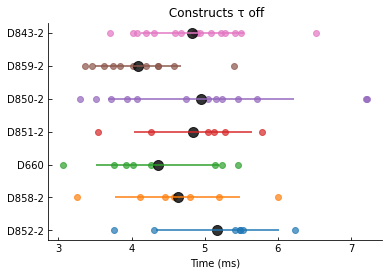

In [ ]:
for group in filtered_data['Construct_Num'].unique():
    group_data = filtered_data[filtered_data['Construct_Num'] == group]
    plt.scatter(group_data['HalfDecayTime'], [group]*len(group_data), label=group, alpha=0.7)
    average_value = group_data['HalfDecayTime'].mean()
    std_value = group_data['HalfDecayTime'].std()
    plt.scatter(average_value, group, color='black', marker='o', label=f'{group} Average',alpha=0.8, s=100)
    plt.errorbar(average_value, group,xerr=std_value)
plt.title(" Constructs τ off")
plt.xlabel("Time (ms)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

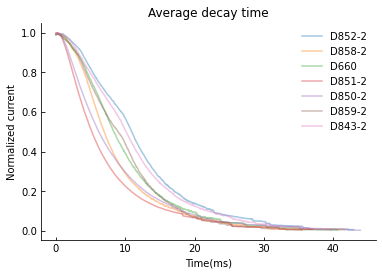

In [ ]:
for group in filtered_data['Construct_Num'].unique():
    group_data = filtered_data[filtered_data['Construct_Num'] == group]
    vectors_array = np.array(group_data['decayTrace'])
    max_length = max(len(vector) for vector in group_data['decayTrace'])
    numnum = 0
    vecSum = np.zeros(max_length)
    for vector in vectors_array:
        numnum = numnum+1
        vectorLength = len(vector)
        diffLength = max_length-vectorLength
        zeroVec = np.zeros(diffLength)
        newVec = np.concatenate([vector,zeroVec])
        vecSum  = vecSum+newVec
    vecSum = vecSum/len(group_data)
    plt.plot(np.arange(len(vecSum))/50,vecSum,label = group,alpha = 0.4)
    plt.xlabel('Time(ms)')
    plt.ylabel('Normalized current')
    plt.title('Average decay time')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tick_params(axis='x', direction='in')
    plt.tick_params(axis='y', direction='in')
    plt.legend(frameon = False)

In [ ]:
def exponential_func(t, a, tau,c):
   return a * np.exp(-t/tau)+c

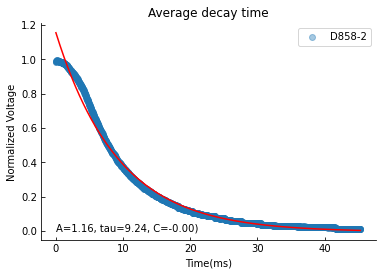

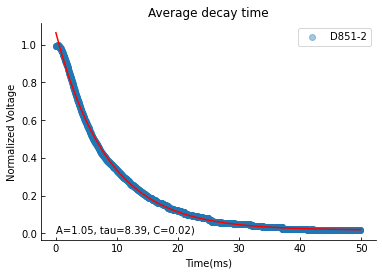

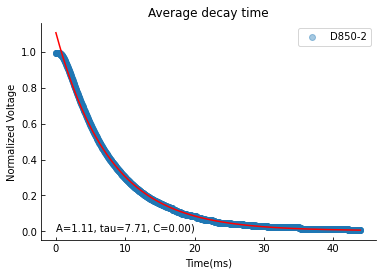

In [ ]:
Include_groups = ['D850-2', 'D851-2','D858-2','D660']
filtered_data = my_dataframe_filterd[my_dataframe_filterd['Construct_Num'].isin(Include_groups)]
for group in filtered_data['Construct_Num'].unique():
    group_data = filtered_data[filtered_data['Construct_Num'] == group]
    vectors_array = np.array(group_data['decayTrace'])
    max_length = max(len(vector) for vector in group_data['decayTrace'])
    numnum = 0
    vecSum = np.zeros(max_length)
    for vector in vectors_array:
        numnum = numnum+1
        vectorLength = len(vector)
        diffLength = max_length-vectorLength
        zeroVec = np.zeros(diffLength)
        newVec = np.concatenate([vector,zeroVec])
        vecSum  = vecSum+newVec
    vecSum = vecSum/len(group_data)
    plt.figure()
    plt.scatter(np.arange(len(vecSum))/50,vecSum,label = group,alpha = 0.4)
    popt, pcov = curve_fit(exponential_func, np.arange(len(vecSum))/50,vecSum)
    a_opt1, tau_apt1,c_apt = popt
    x_fit1 = np.arange(len(vecSum))/50  # Generate x-values for the fitted curve
    y_fit1 = exponential_func(x_fit1, a_opt1,tau_apt1,c_apt)  # Evaluate the fitted curve
    plt.plot(x_fit1, y_fit1, 'r-')
    plt.text(0,0,'A={:.2f}, tau={:.2f}, C={:.2f})'.format(a_opt1, tau_apt1,c_apt, fontsize=12, color='black'))
    plt.xlabel('Time(ms)')
    plt.ylabel('Normalized Voltage')
    plt.title('Average decay time')
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tick_params(axis='x', direction='in')
    plt.tick_params(axis='y', direction='in')
    plt.show()

In [ ]:
# folder_path   = (r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\Weizmann\DATA_sept23")
# for foldername in os.listdir(folder_path):
#     folder_path_in = os.path.join(folder_path,foldername+ '\\EPHYS\\')
#     for files in os.listdir(folder_path_in):
#         file_path_in = os.path.join(folder_path_in,files)
#         if os.path.isfile(file_path_in):
#             try:
#                 abf = pyabf.ABF(file_path_in)
#                 abf.setSweep(5,0,baseline=[0.1,0.5])
#                 plt.figure()
#                 plt.plot(abf.sweepX,abf.sweepY)
#                 plt.title("{}".format(abf.abfFileComment))
#             except:
#                 continue

In [ ]:
file_path = r"C:\Users\omeri\OneDrive - weizmann.ac.il\Desktop\for group meeting"

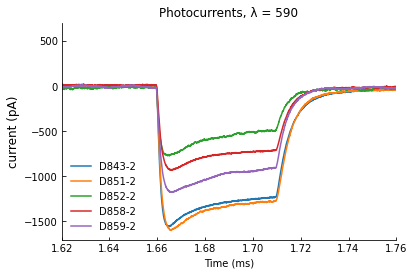

In [ ]:
plt.figure()
for file in os.listdir(file_path):
        file_path_in = os.path.join(file_path,file)
        abf = pyabf.ABF(file_path_in)
        abf.setSweep(5,0,baseline=[0.1,0.5])
        file_name_string = abf.abfFileComment
        fileNameParse = parse_file_name(file_name_string)
        label_plot = fileNameParse['construct']
        plt.plot(abf.sweepX,abf.sweepY,label = label_plot)
        plt.title("{}".format(abf.abfFileComment))
plt.xlim([1.62,1.76])
plt.title('Photocurrents, λ = 590',fontsize=12)
plt.ylabel('current (pA)',fontsize=12)
plt.xlabel('Time (seconds)')
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon = False)
plt.show()